In [1]:
import random, math, os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from gan import datasets, networks, utils

In [4]:
mnist = datasets.fetch_mnist()

In [5]:
latent_dim = 100
feature_map_size = 64

gen_net = networks.Generator(latent_dim = latent_dim, feature_map_size = feature_map_size).to(device)
disc_net = networks.Discriminator().to(device)

In [6]:
lr = 0.0002
batch_size = 128
workers = 2

In [13]:
loss_function = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

# Establish convention for real and fake labels during training
REAL_LABEL = 1.
FAKE_LABEL = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(disc_net.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(gen_net.parameters(), lr=lr, betas=(0.5, 0.999))

In [8]:
dataloader = torch.utils.data.DataLoader(mnist.data, batch_size=batch_size,
                                         shuffle=True, drop_last = True, num_workers=workers)

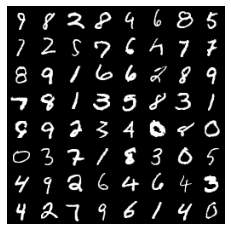

In [9]:
utils.plot_img(next(iter(dataloader))[:64], file_name = "real_mnist.jpg")

Starting Training Loop...
[0/20][0/546] Loss_D: 2.141 Loss_G 0.305 D(x): 0.641
[0/20][50/546] Loss_D: 1.27 Loss_G 1.113 D(x): 0.588
[0/20][100/546] Loss_D: 1.249 Loss_G 1.255 D(x): 0.538
[0/20][150/546] Loss_D: 0.975 Loss_G 1.742 D(x): 0.618
[0/20][200/546] Loss_D: 1.151 Loss_G 1.239 D(x): 0.551
[0/20][250/546] Loss_D: 1.062 Loss_G 1.086 D(x): 0.585
[0/20][300/546] Loss_D: 1.181 Loss_G 1.135 D(x): 0.538
[0/20][350/546] Loss_D: 1.204 Loss_G 0.932 D(x): 0.549
[0/20][400/546] Loss_D: 1.215 Loss_G 0.781 D(x): 0.498
[0/20][450/546] Loss_D: 1.177 Loss_G 0.933 D(x): 0.522
[0/20][500/546] Loss_D: 1.199 Loss_G 1.043 D(x): 0.529
[1/20][0/546] Loss_D: 1.206 Loss_G 0.76 D(x): 0.472
[1/20][50/546] Loss_D: 1.21 Loss_G 0.9 D(x): 0.528
[1/20][100/546] Loss_D: 1.244 Loss_G 1.051 D(x): 0.642
[1/20][150/546] Loss_D: 1.192 Loss_G 0.865 D(x): 0.554
[1/20][200/546] Loss_D: 1.208 Loss_G 1.02 D(x): 0.604
[1/20][250/546] Loss_D: 1.233 Loss_G 0.85 D(x): 0.482
[1/20][300/546] Loss_D: 1.234 Loss_G 0.826 D(x): 0.5

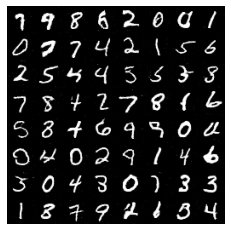

In [17]:
iters = 0

assert dataloader.drop_last # We assume the last batch to be dropped if incomplete

print("Starting Training Loop...")
nb_epochs = 20
for i_epoch in range(nb_epochs):
    for i, data in enumerate(dataloader, 0):
        
        data = data.to(device)
        
        """
        Training of the discriminator with actual data
        """
        disc_net.zero_grad()
        label = torch.full((batch_size,), REAL_LABEL, dtype=torch.float, device=device)

        output = disc_net(data.float().unsqueeze(1)).view(-1)
        loss_real = loss_function(output, label)
        loss_real.backward()
        
        D_x = output.mean().item()

        """
        Training of the discriminator with all fake data
        """
        fake = gen_net(gen_net.get_noise(device, batch_size))
        label.fill_(FAKE_LABEL)
        
        output = disc_net(fake.detach()).view(-1)
        loss_fake = loss_function(output, label)
        loss_fake.backward()
        
        loss_disc = loss_real.item() + loss_fake.item()
        
        optimizerD.step()
        
        """
        Training the generator to make better fakes
        """
        
        gen_net.zero_grad()
        label.fill_(REAL_LABEL) # From the generator side, it must generate real imgs
        
        output = disc_net(fake).view(-1)
        
        loss_gen = loss_function(output, label)
        loss_gen.backward()
        
        optimizerG.step()


        """
        Print progress of training
        """
        if i % 50 == 0:
            print(f"[{i_epoch}/{nb_epochs}][{i}/{len(dataloader)}] Loss_D: {round(loss_disc, 3)} Loss_G {round(loss_gen.item(), 3)} D(x): {round(D_x, 3)}")

        if (iters % 500 == 0) or ((i_epoch -1 == nb_epochs) and (i == len(dataloader)-1)):
            """
            Save the fakes each 500 iterations and at the end of the training
            """
            with torch.no_grad():
                fake = gen_net(fixed_noise).detach().cpu()
                utils.plot_img(fake, file_name = f"fake_{iters}.jpg")

        iters += 1